## Importation des données

In [5]:
#Some Basic Imports
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd             # For handling data

## Recuperation des données

In [6]:
train_path= './tb_xray/train/'
valid_path = './tb_xray/valid/'
test_path = './tb_xray/test/'

In [7]:
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 16 
#The dimension of the images we are going to define is 500x500 img_height = 500
img_height = 500
img_width = 500

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                rescale = 1./255,
                                #shear_range = 0,
                                #zoom_range = 0,
                                horizontal_flip = True,          
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [9]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
      class_mode='binary',
      batch_size=batch_size
      )

valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      ) 

Found 2500 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 1100 images belonging to 2 classes.


## Affichage des données

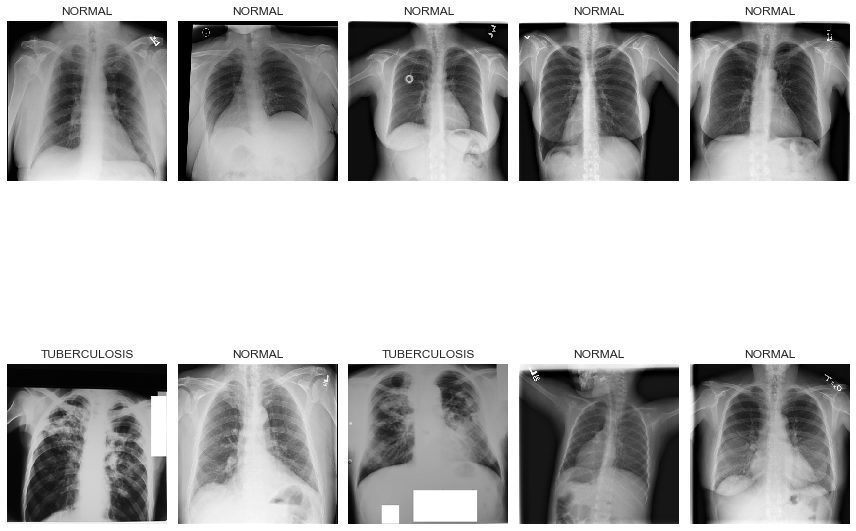

In [10]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'TUBERCULOSIS'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()


##  Creation du modéle

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [12]:
cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 128))

cnn.add(Dense(activation = 'relu', units = 64))

cnn.add(Dense(activation = 'sigmoid', units = 1))


In [13]:
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [14]:
cnn.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 498, 498, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 247, 247, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 121, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 64)        1

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(cnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [16]:
early = EarlyStopping(monitor= "val_loss", mode= "min", patience= 3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [17]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

C:\Users\DELL INSPIRON\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 0.625, 1: 2.5}


In [18]:
history = cnn.fit(train,epochs=10, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
157/157 [==============================] - 576s 4s/step - loss: 0.4596 - accuracy: 0.7948 - val_loss: 0.2122 - val_accuracy: 0.8973
Epoch 2/10
157/157 [==============================] - 578s 4s/step - loss: 0.2796 - accuracy: 0.8888 - val_loss: 0.2724 - val_accuracy: 0.8691
Epoch 3/10
157/157 [==============================] - 586s 4s/step - loss: 0.2233 - accuracy: 0.9100 - val_loss: 0.2066 - val_accuracy: 0.9191
Epoch 4/10
157/157 [==============================] - 578s 4s/step - loss: 0.1653 - accuracy: 0.9380 - val_loss: 0.2464 - val_accuracy: 0.8964
Epoch 5/10
157/157 [==============================] - 578s 4s/step - loss: 0.1457 - accuracy: 0.9476 - val_loss: 0.1222 - val_accuracy: 0.9609
Epoch 6/10
157/157 [==============================] - 579s 4s/step - loss: 0.1101 - accuracy: 0.9636 - val_loss: 0.1599 - val_accuracy: 0.9436
Epoc

## Evaluation du modéle

<AxesSubplot:>

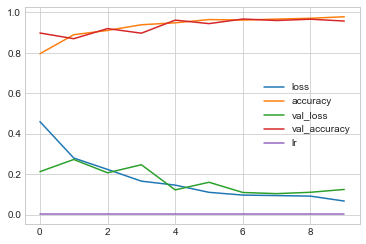

In [19]:
pd.DataFrame(cnn.history.history).plot()

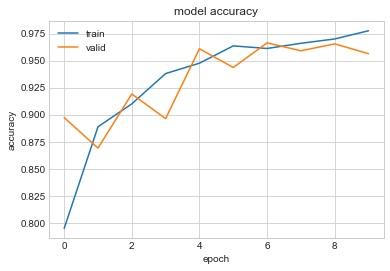

In [20]:
plt.style.use('seaborn-whitegrid')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

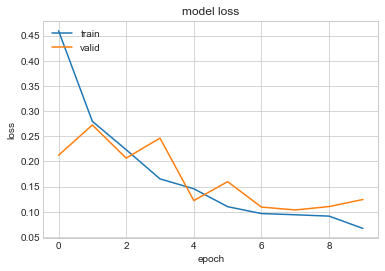

In [21]:
plt.style.use('seaborn-whitegrid')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [22]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

38/38 [==============================] - 33s 867ms/step - loss: 0.1466 - accuracy: 0.9267
The testing accuracy is : 92.66666769981384 %


In [23]:
preds = cnn.predict(test,verbose=1)

38/38 [==============================] - 36s 925ms/step


In [24]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

<AxesSubplot:>

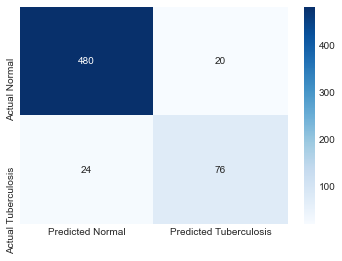

In [30]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Tuberculosis"],
columns=["Predicted Normal", "Predicted Tuberculosis"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d",cmap='Blues')

In [31]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','TUBERCULOSIS']))

              precision    recall  f1-score   support

      NORMAL       0.95      0.96      0.96       500
TUBERCULOSIS       0.79      0.76      0.78       100

    accuracy                           0.93       600
   macro avg       0.87      0.86      0.87       600
weighted avg       0.93      0.93      0.93       600



(600, 500, 500, 1)
(600,)


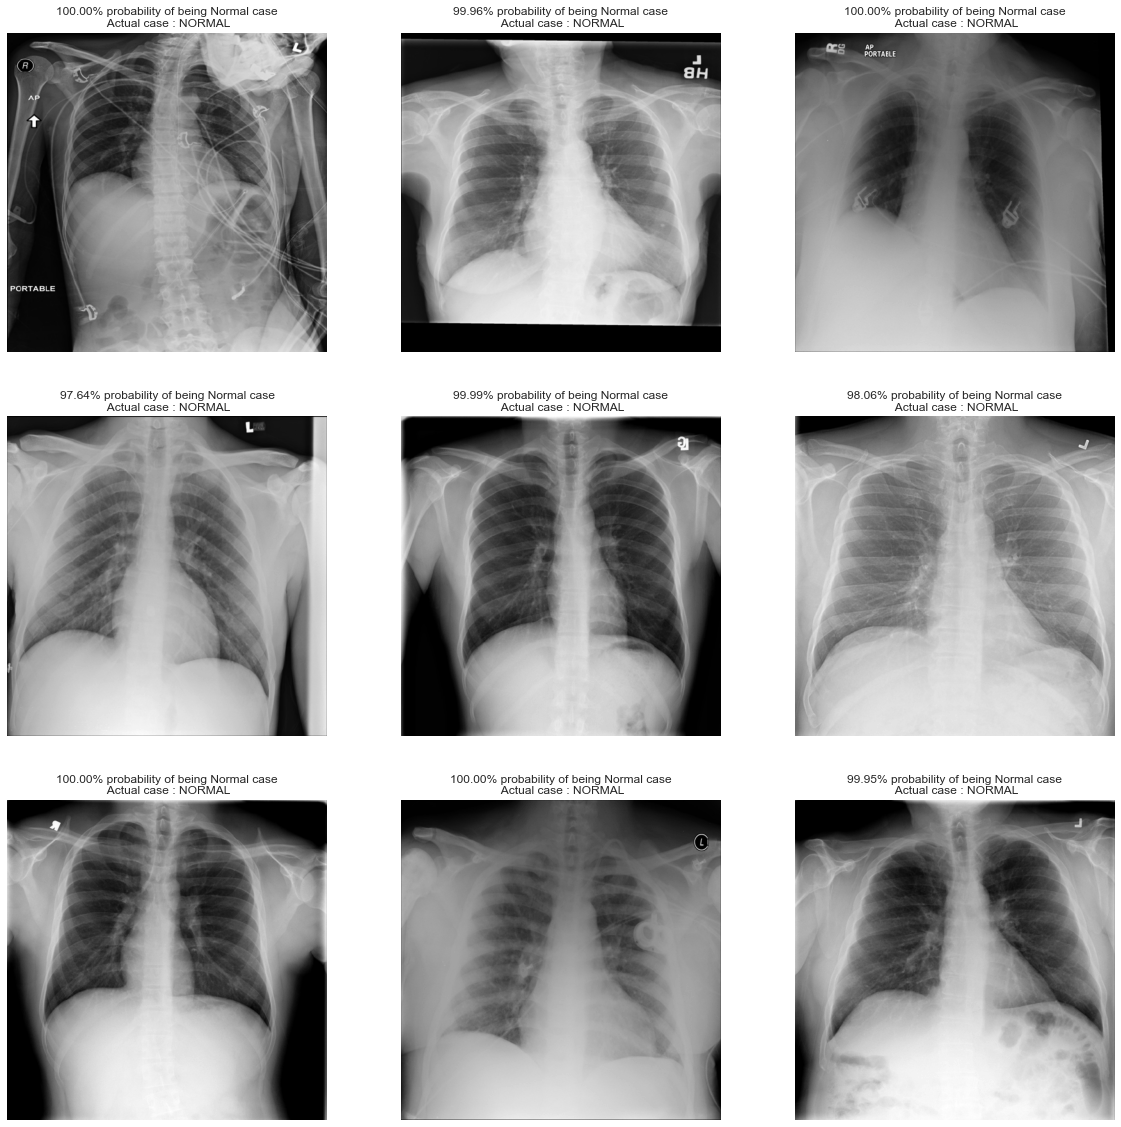

In [32]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)
#this little code above extracts the images from test Data iterator without shuffling the sequence
# x contains image array and y has labels 
dic = {0:'NORMAL', 1:'TUBERCULOSIS'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5: 
    out = ('{:.2%} probability of being Tuberculosis case'.format(preds[i][0]))
      
      
  else: 
    out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
  plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]),cmap='gray')
  plt.axis('off')
plt.show()

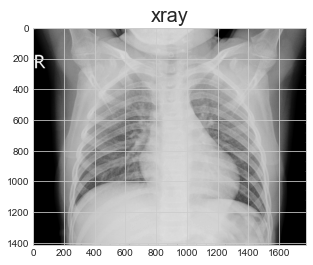

In [33]:
img = plt.imread('image1.jpeg')
plt.imshow(img,cmap='gray')
plt.title('xray',fontsize=20)
plt.show()

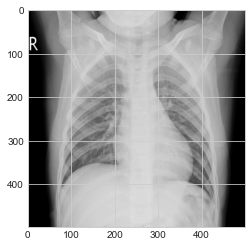

In [34]:
from skimage.transform import resize
rsz_img = resize(img,(500,500,1))
plt.imshow(rsz_img,cmap='gray')

In [35]:
im_pred = cnn.predict(np.array([rsz_img]))
im_pred

array([[0.06095645]], dtype=float32)

In [36]:
num = im_pred[0,0]*100
x = round(num,2)
txt = 'Cet individu a {} % de chance d\'étre la NORMAL'
print(txt.format(x))

Cet individu a 6.1 % de chance d'étre la NORMAL


In [37]:
cnn.save('tuberculosis_classifier.h5')

In [38]:
from tensorflow import keras
model = keras.models.load_model('tuberculosis_classifier.h5')